## SJM-BL Simulation study (scenario 1)
### 1.0 Loading packages

In [152]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Hidden Markov Model utilities
from hmmlearn.hmm import GaussianHMM
from sklearn.cluster import KMeans

# Sparse Jump Model utilities (custom package)
from jumpmodels.sparse_jump import SparseJumpModel
from jumpmodels.preprocess import StandardScalerPD, DataClipperStd

# Portfolio optimization (PyPortfolioOpt)
from pypfopt.black_litterman import BlackLittermanModel, market_implied_risk_aversion
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import expected_returns, risk_models


### 2.0 Data Simulation

#### 2.1 Simulating the 1-state data
We are simulating 6 fictional assets which are representing the 6 factors in our framework
- **1-State:** A single regime with Student‑t returns.
- **2-State:** A two-regime (bull/bear) HMM with state-dependent parameters.
- **3-State:** A three-regime HMM with specified means and volatilitie

All assets have the same expected return and volatility.

In [153]:
ASSETS = ["Value", "Growth", "LowVol", "Size", "Momentum", "Quality"]
N_ASSETS = len(ASSETS)
CONST_RET = 0.000461  # Hypothetical constant daily return used in some approaches
RISK_FREE_RATE = 0.02 / 252
TRANSACTION_COST = 0.0005
BL_TAU = 0.1  # Black-Litterman tau parameter
rng = np.random.default_rng(40) #Global random seed


In [154]:
def simulate_1state_data(num_days):
    """
    Simulate a single-regime (1-state) process where returns are i.i.d.
    Student-t with fixed parameters across all days.
    """
    mu = 0.000461
    sig = 0.008388
    dof = 5

    # Correlation matrix: all off-diagonals = 0.185, diag = 1.0
    corr = np.full((N_ASSETS, N_ASSETS), 0.185)
    np.fill_diagonal(corr, 1.0)
    cov = np.outer(np.full(N_ASSETS, sig), np.full(N_ASSETS, sig)) * corr

    # Generate random draws from a t-distribution-like process
    z = rng.multivariate_normal(mean=np.zeros(N_ASSETS), cov=cov, size=num_days)
    chi = rng.chisquare(dof, size=num_days)
    factor = np.sqrt(dof / chi)[:, None]  # scaling for t distribution

    rets = mu + z * factor
    return pd.DataFrame(rets, columns=ASSETS)

#### 2.2 Simulating 2-state data

This function simulates a 2-state HMM (bull/bear) with state‐dependent Student‑t returns.

In [155]:
def simulate_2state_data(num_days):
    """
    Simulate a 2-state HMM (bull/bear) with state-dependent Student-t returns.
    Returns the simulated DataFrame plus the true hidden states.
    """
    # Transition probabilities
    transmat = np.array([
        [0.9976, 0.0024],
        [0.0232, 0.9768]
    ])
    states = np.zeros(num_days, dtype=int)
    states[0] = rng.integers(2)

    for t in range(1, num_days):
        states[t] = rng.choice(2, p=transmat[states[t - 1]])

    # State-specific means / std dev
    mu_dict = {0: 0.0006, 1: -0.000881}
    sig_dict = {0: 0.00757, 1: 0.0163}
    corr = np.full((N_ASSETS, N_ASSETS), 0.185)
    np.fill_diagonal(corr, 1.0)

    rets = np.zeros((num_days, N_ASSETS))
    dof = 5
    for t in range(num_days):
        s = states[t]
        mu_s = np.full(N_ASSETS, mu_dict[s])
        sig_s = np.full(N_ASSETS, sig_dict[s])
        cov_s = np.outer(sig_s, sig_s) * corr

        z = rng.multivariate_normal(mean=np.zeros(N_ASSETS), cov=cov_s)
        chi = rng.chisquare(dof)
        factor = np.sqrt(dof / chi)
        rets[t] = mu_s + factor * z

    return pd.DataFrame(rets, columns=ASSETS), states

#### 2.3 Simulating 3-state data

We are simulating 6 fictional assets which are representing the 6 factors in our framework

In [156]:
def simulate_3state_data(num_days):
    """
    Simulate a 3-state HMM with specified means/volatilities for each state.
    Returns the simulated DataFrame plus the true hidden states.
    """
    # Transition probabilities
    transmat = np.array([
        [0.9989, 0.0004, 0.0007],
        [0.0089, 0.9904, 0.0007],
        [0.0089, 0.0004, 0.9907]
    ])
    states = np.zeros(num_days, dtype=int)
    states[0] = rng.integers(3)

    for t in range(1, num_days):
        states[t] = rng.choice(3, p=transmat[states[t - 1]])

    mu_list = [0.0008, 0.0, -0.003586]
    sig_list = [0.0070, 0.0050, 0.01897]

    corr = np.full((N_ASSETS, N_ASSETS), 0.185)
    np.fill_diagonal(corr, 1.0)

    rets = np.zeros((num_days, N_ASSETS))
    dof = 5
    for t in range(num_days):
        s = states[t]
        mu_s = np.full(N_ASSETS, mu_list[s])
        sig_s = np.full(N_ASSETS, sig_list[s])
        cov_s = np.outer(sig_s, sig_s) * corr

        z = rng.multivariate_normal(mean=np.zeros(N_ASSETS), cov=cov_s)
        chi = rng.chisquare(dof)
        factor = np.sqrt(dof / chi)
        rets[t] = mu_s + factor * z

    return pd.DataFrame(rets, columns=ASSETS), states

### 3.0 Training Regime Models

#### 3.1 Training HMM using kmeans clustering initialization

In [157]:
def run_mle(observations, n_components=2, init_type='default', seed=None):
    """
    Fit a Gaussian HMM to the data with either default or K-means initialization.
    This is a more general function that returns (model, pred_states).
    """
    model = GaussianHMM(n_components=n_components, covariance_type='diag',
                        n_iter=100, random_state=seed)

    if init_type == 'default':
        # Example for 2 components:
        model.startprob_ = np.array([1.0, 0.0])
        model.transmat_ = np.array([[0.9, 0.1],
                                    [0.1, 0.9]])
        model.means_ = np.zeros((n_components, observations.shape[1]))
        model.covars_ = np.full((n_components, observations.shape[1]), 1e-2)
        # Disable re-initialization of parameters
        model.init_params = ''
    elif init_type == 'kmeans':
        kmeans = KMeans(n_clusters=n_components, n_init=10, random_state=seed)
        labels = kmeans.fit_predict(observations)
        means = []
        covars = []
        for i in range(n_components):
            obs_i = observations[labels == i]
            means.append(np.mean(obs_i, axis=0))
            covars.append(np.var(obs_i, axis=0) + 1e-2)
        model.startprob_ = np.ones(n_components) / n_components
        model.transmat_ = np.ones((n_components, n_components)) / n_components
        model.means_ = np.array(means)
        model.covars_ = np.array(covars)
        model.init_params = ''

    model.fit(observations)
    pred_states = model.predict(observations)
    return model, pred_states


In [158]:
def run_mle_default(observations, seed=None):
    """
    Convenience wrapper for default initialization (calls run_mle).
    """
    return run_mle(observations, init_type='default', seed=seed)


def run_mle_kmeans(observations, seed=None):
    """
    Convenience wrapper for K-means initialization (calls run_mle).
    """
    return run_mle(observations, init_type='kmeans', seed=seed)


def train_hmm_single_asset_default(series, n_components=2, random_state=42):
    """
    Train a single-asset GaussianHMM using default initialization.
    """
    X = series.values.reshape(-1, 1)
    model, _ = run_mle_default(X, seed=random_state)
    return model


def train_hmm_single_asset_kmeans(series, n_components=2, random_state=42):
    """
    Train a single-asset GaussianHMM using K-means initialization.
    """
    X = series.values.reshape(-1, 1)
    model, _ = run_mle_kmeans(X, seed=random_state)
    return model

#### 3.2 Training Sparse Jump model with max_feats=9 and lambda=80
##### 3.2.1 Defining feature selection framework

In [159]:
def compute_temporal_features_1d(y, window_len):
    """
    Compute 9 temporal features for a single series y,
    using a specified window length. Each row is for day t.
    """
    T = len(y)
    feats = np.zeros((T, 9))
    half = (window_len - 1) // 2

    for t in range(T):
        # 1) Current return
        feats[t, 0] = y[t]
        # 2) Backward difference magnitude
        feats[t, 1] = abs(y[t] - y[t - 1]) if t > 0 else 0.0
        # 3) Forward difference magnitude
        feats[t, 2] = abs(y[t + 1] - y[t]) if t < T - 1 else 0.0

        left_c = max(0, t - half)
        right_c = min(T, t + half + 1)
        window_c = y[left_c:right_c]
        # 4) Rolling mean (centered)
        feats[t, 3] = np.mean(window_c)
        # 5) Rolling std (centered)
        feats[t, 4] = np.std(window_c)

        left_l = max(0, t - window_len)
        window_l = y[left_l:t]
        # 6) Rolling mean (left)
        feats[t, 5] = np.mean(window_l) if len(window_l) > 0 else 0.0
        # 7) Rolling std (left)
        feats[t, 6] = np.std(window_l) if len(window_l) > 0 else 0.0

        window_r = y[t:t + window_len]
        # 8) Rolling mean (right)
        feats[t, 7] = np.mean(window_r) if len(window_r) > 0 else 0.0
        # 9) Rolling std (right)
        feats[t, 8] = np.std(window_r) if len(window_r) > 0 else 0.0

    return feats


def combine_features_1d(y, window_list=[5, 13]):
    """
    Combine 9-feature blocks for different window lengths into a single matrix.
    """
    feat_list = []
    for w in window_list:
        feat_list.append(compute_temporal_features_1d(y, w))
    return np.hstack(feat_list)

In [160]:
def train_sjm_single_asset(series, n_components=2, max_feats=9, lam=50.0, random_state=42):
    """
    Train a 1D Sparse Jump Model for a single asset. Builds simple
    temporal features, standardizes, then fits the SJM with n_components.
    """
    # Build features
    y = series.values
    X_raw = combine_features_1d(y)

    # Outlier clipping & standardization
    clipper = DataClipperStd(mul=3.0)
    scaler = StandardScalerPD()

    X_clipped = clipper.fit_transform(pd.DataFrame(X_raw))
    X_scaled = scaler.fit_transform(X_clipped)
    X_arr = X_scaled.values

    # Fit the SJM
    sjm = SparseJumpModel(
        n_components=n_components,
        max_feats=max_feats,
        jump_penalty=lam,
        cont=False,
        max_iter=20,
        random_state=random_state
    )
    sjm.fit(X_arr)
    return sjm


### 4.0 Allocation simulation

#### 4.1 Allocation workhorse functions
In this code we create the in which we fit the following models (each done in a seperate for loop such that we can store the relevant data such as return, weights, etc. in seperate dfs):
1. Equal weigted
2. Inverse volatility weighted
3. Mean-Variance-Optimal static portfolio
4. Hidden Markov Model Black Litterman where infered states are the identified regimes
5. Sparse Jump Model Black Litterman where infered states are the identified regimes

In [161]:
def backtest_portfolio(returns, weights):
    """
    Given a static weight vector and a DataFrame of returns (T x N),
    compute the portfolio's value over time (starting at 1.0).
    """
    T = len(returns)
    portfolio_vals = np.zeros(T)
    portfolio_vals[0] = 1.0
    for t in range(T - 1):
        ret_t = returns.iloc[t].values
        portfolio_vals[t + 1] = portfolio_vals[t] * (1.0 + np.dot(weights, ret_t))
    return portfolio_vals


def equal_weight_allocation(n_assets):
    """
    Return an equal-weight vector of length n_assets.
    """
    return np.ones(n_assets) / n_assets


def inverse_vol_weights(returns):
    """
    Inverse-vol weighting for a DataFrame of returns.
    """
    stds = returns.std(axis=0).values + 1e-12
    w = 1.0 / stds
    return w / w.sum()


def static_mvo_allocation(returns):
    """
    Static MVO with a constant prior mean, fully invested, long-only.
    """
    mu = pd.Series(CONST_RET, index=returns.columns)
    cov = risk_models.sample_cov(returns)

    ef = EfficientFrontier(mu, cov, weight_bounds=(0, 1), solver="SCS")
    ef_weights = ef.max_sharpe(risk_free_rate=RISK_FREE_RATE)
    return ef.clean_weights()


def black_litterman_allocation(view_vector, prior_cov):
    """
    Compute BL weights with fallback if no asset exceeds the risk-free rate.
    """
    pi = pd.Series(CONST_RET, index=prior_cov.columns)
    viewdict = {asset: view for asset, view in zip(ASSETS, view_vector)}

    bl = BlackLittermanModel(
        cov_matrix=prior_cov,
        pi=pi,
        absolute_views=viewdict,
        tau=BL_TAU,
        risk_aversion=1
    )

    bl_rets = bl.bl_returns()  # Posterior expected returns
    bl_cov = bl.bl_cov()       # Posterior covariance

    ef = EfficientFrontier(bl_rets, bl_cov, weight_bounds=(0, 1), solver="SCS")
    
    # --- Fallback if none of the BL returns exceed the risk-free rate ---
    if max(bl_rets) <= RISK_FREE_RATE:
        ef_weights = ef.min_volatility()
    else:
        ef_weights = ef.max_sharpe(risk_free_rate=RISK_FREE_RATE)
    # -------------------------------------------------------------------

    clean_weights = ef.clean_weights()
    w_array = np.array([clean_weights[a] for a in prior_cov.columns])
    return w_array

### 5.0 Performance metric evaluation:
Here we divide the performance metric into. We assume 250 data points to be 1 year off trading:
1. Return-Based Metrics 

Annualized Return: Average return per year. 

Cumulative Return: Total portfolio growth over time. 

2. Risk-Based Metrics 

Volatility: Standard deviation of returns. 

Downside Deviation: Measures negative return fluctuations. 

Max Drawdown (MDD): Largest portfolio decline from peak to trough. 

3. Risk-Adjusted Metrics 

Sharpe Ratio: Return per unit of total risk. 

Sortino Ratio: Return per unit of downside risk. 

Calmar Ratio: Return relative to max drawdown. 

4. Portfolio Stability & Adaptation 

Turnover Rate: Measures frequency of asset reallocation. 


We further split the performance three seperate tables with 1-state process, 2-state process, 3-state process




In [162]:
def compute_performance_metrics(portfolio_vals, weight_history=None, annual_factor=250):
    """
    Compute return, risk, and risk-adjusted performance measures from a
    time series of portfolio values.
    """
    pv = np.asarray(portfolio_vals)
    rets = np.diff(pv) / pv[:-1]

    ann_ret = rets.mean() * annual_factor
    cum_ret = pv[-1] / pv[0] - 1
    ann_vol = rets.std() * np.sqrt(annual_factor)

    negative_rets = rets[rets < 0]
    ddev = negative_rets.std() * np.sqrt(annual_factor) if len(negative_rets) > 0 else 0.0
    max_dd = (pv / np.maximum.accumulate(pv) - 1).min()

    sharpe = ann_ret / (ann_vol + 1e-12)
    sortino = ann_ret / ddev if ddev > 1e-12 else np.nan
    calmar = ann_ret / abs(max_dd) if max_dd < 0 else np.nan

    if weight_history is not None and len(weight_history) > 1:
        turnover_list = []
        for t in range(1, len(weight_history)):
            turnover_list.append(np.sum(np.abs(weight_history[t] - weight_history[t - 1])))
        avg_turnover = np.mean(turnover_list)
    else:
        avg_turnover = 0.0

    return {
        "Annualized Return": ann_ret,
        "Cumulative Return": cum_ret,
        "Volatility": ann_vol,
        "Downside Deviation": ddev,
        "Max Drawdown": max_dd,
        "Sharpe Ratio": sharpe,
        "Sortino Ratio": sortino,
        "Calmar Ratio": calmar,
        "Turnover Rate": avg_turnover,
    }

#### 5.1 Regime based allocation

In [163]:

def regime_based_bl_backtest(returns, test_states, regime_means, prior_cov, train_means):
    """
    For each day, if ANY asset changes regime, we recompute the BL weights
    based on that day's regime for each asset. 'regime_means' is a list of
    dicts where regime_means[i][st] is the mean return for asset i, regime st.

    'train_means' is a fallback for any state that didn't appear in training.
    """
    T = len(returns)
    n_assets = returns.shape[1]

    pv = np.zeros(T)
    pv[0] = 1.0
    w_hist = np.zeros((T, n_assets))
    w_hist[0] = np.ones(n_assets) / n_assets

    for t in range(T - 1):
        r_t = returns.iloc[t].values
        pv[t + 1] = pv[t] * (1.0 + np.dot(w_hist[t], r_t))

        if t == 0:
            changed = True
        else:
            # If ANY asset changed state from t-1 to t, we treat as regime change
            changed = not np.all(test_states[t] == test_states[t - 1])

        if changed:
            # Build new "view" vector
            Q = []
            for i in range(n_assets):
                curr_state = test_states[t, i]
                # If dictionary doesn't have that state, fallback
                Q.append(regime_means[i].get(curr_state, train_means[i]))
            w_new = black_litterman_allocation(Q, prior_cov)
        else:
            w_new = w_hist[t]

        w_hist[t + 1] = w_new

        # Transaction cost (if applicable)
        if t > 0:
            turnover = np.sum(np.abs(w_hist[t + 1] - w_hist[t]))
            cost = TRANSACTION_COST * turnover
            pv[t + 1] *= (1.0 - cost)

    # Apply the final day's return
    r_last = returns.iloc[-1].values
    pv[-1] = pv[-2] * (1.0 + np.dot(w_hist[-2], r_last))

    return pv, w_hist


def get_regime_means_single_asset(returns_series, states):
    """
    Create a dict of regime -> mean-return. If the model is 2-state,
    we typically expect states {0,1}, but if only one cluster was used,
    the set might be just {0}.
    """
    unique_states = np.unique(states)
    means = {}
    for st in unique_states:
        means[st] = returns_series[states == st].mean()
    return means

#### 6.0 Simulation

In [164]:
def run_allocation(df, scenario_name=""):
    """
    Splits df into train/test. Fits single-asset HMM (default, kmeans) & SJM for each
    of the 6 assets, then runs:
      1) EW
      2) Inverse Vol
      3) Static MVO
      4) HMM-BL (Default init)
      5) HMM-BL (K-Means init)
      6) SJM-BL
    """
    # 80/20 split
    split_idx = int(len(df) * 0.8)
    df_train = df.iloc[:split_idx]
    df_test = df.iloc[split_idx:]

    prior_cov = df_train.cov()  # used in BL

    # Prepare arrays to hold states
    hmm_models_default = []
    hmm_models_kmeans = []
    sjm_models = []

    hmm_states_default_train = np.zeros((split_idx, N_ASSETS), dtype=int)
    hmm_states_kmeans_train = np.zeros((split_idx, N_ASSETS), dtype=int)
    sjm_states_train = np.zeros((split_idx, N_ASSETS), dtype=int)

    # ===== TRAINING PHASE =====
    for i, asset in enumerate(ASSETS):
        series_train = df_train[asset]

        # HMM (default init)
        hmm_mod_default = train_hmm_single_asset_default(series_train)
        hmm_mod_states_default = hmm_mod_default.predict(series_train.values.reshape(-1, 1))
        hmm_models_default.append(hmm_mod_default)
        hmm_states_default_train[:, i] = hmm_mod_states_default

        # HMM (kmeans init)
        hmm_mod_kmeans = train_hmm_single_asset_kmeans(series_train)
        hmm_mod_states_kmeans = hmm_mod_kmeans.predict(series_train.values.reshape(-1, 1))
        hmm_models_kmeans.append(hmm_mod_kmeans)
        hmm_states_kmeans_train[:, i] = hmm_mod_states_kmeans

        # Sparse Jump Model
        sjm_mod = train_sjm_single_asset(series_train, n_components=2)
        # SJM states on train
        X_raw = combine_features_1d(series_train.values)
        clipper = DataClipperStd(mul=3.0)
        scaler = StandardScalerPD()
        X_clipped = clipper.fit_transform(pd.DataFrame(X_raw))
        X_scaled = scaler.fit_transform(X_clipped)
        sjm_states = sjm_mod.predict(X_scaled.values)
        sjm_models.append(sjm_mod)
        sjm_states_train[:, i] = sjm_states

    # Compute in-sample regime means (for each asset, each model)
    hmm_regime_means_default = []
    hmm_regime_means_kmeans = []
    sjm_regime_means = []
    train_means_per_asset = []  # fallback for unobserved states in test

    for i in range(N_ASSETS):
        asset_train = df_train.iloc[:, i]
        train_means_per_asset.append(asset_train.mean())

        hmm_regime_means_default.append(
            get_regime_means_single_asset(asset_train, hmm_states_default_train[:, i])
        )
        hmm_regime_means_kmeans.append(
            get_regime_means_single_asset(asset_train, hmm_states_kmeans_train[:, i])
        )
        sjm_regime_means.append(
            get_regime_means_single_asset(asset_train, sjm_states_train[:, i])
        )

    # ===== TEST PHASE =====
    df_test_values = df_test.values
    T_test = len(df_test)

    hmm_states_default_test = np.zeros((T_test, N_ASSETS), dtype=int)
    hmm_states_kmeans_test = np.zeros((T_test, N_ASSETS), dtype=int)
    sjm_states_test = np.zeros((T_test, N_ASSETS), dtype=int)

    # Predict states in test
    for i, asset in enumerate(ASSETS):
        # HMM (default)
        asset_series_test = df_test[asset].values.reshape(-1, 1)
        hmm_states_default_test[:, i] = hmm_models_default[i].predict(asset_series_test)

        # HMM (kmeans)
        hmm_states_kmeans_test[:, i] = hmm_models_kmeans[i].predict(asset_series_test)

        # SJM
        X_test_raw = combine_features_1d(df_test[asset].values)
        clipper = DataClipperStd(mul=3.0)
        scaler = StandardScalerPD()
        X_test_clipped = clipper.fit_transform(pd.DataFrame(X_test_raw))
        X_test_scaled = scaler.fit_transform(X_test_clipped)
        sjm_states_test[:, i] = sjm_models[i].predict(X_test_scaled.values)

    # ============ STRATEGIES ============
    # 1) EW
    w_ew = equal_weight_allocation(N_ASSETS)
    pv_ew = backtest_portfolio(df_test, w_ew)
    w_hist_ew = np.tile(w_ew, (T_test, 1))

    # 2) Inverse Vol
    w_iv = inverse_vol_weights(df_test)
    pv_iv = backtest_portfolio(df_test, w_iv)
    w_hist_iv = np.tile(w_iv, (T_test, 1))

    # 3) Static MVO (fit on train sample, apply to test)
    w_mvo_dict = static_mvo_allocation(df_train)
    w_mvo_arr = np.array([w_mvo_dict[a] for a in ASSETS])
    pv_mvo = backtest_portfolio(df_test, w_mvo_arr)
    w_hist_mvo = np.tile(w_mvo_arr, (T_test, 1))

    # 4) HMM-BL (Default)
    pv_hmmbl_default, w_hmmbl_default = regime_based_bl_backtest(
        df_test, hmm_states_default_test,
        hmm_regime_means_default,
        prior_cov,
        train_means_per_asset
    )

    # 5) HMM-BL (K-Means)
    pv_hmmbl_kmeans, w_hmmbl_kmeans = regime_based_bl_backtest(
        df_test, hmm_states_kmeans_test,
        hmm_regime_means_kmeans,
        prior_cov,
        train_means_per_asset
    )

    # 6) SJM-BL
    pv_sjmbl, w_sjmbl = regime_based_bl_backtest(
        df_test, sjm_states_test,
        sjm_regime_means,
        prior_cov,
        train_means_per_asset
    )

    # ===== PERFORMANCE =====
    perf = {
        "EW":                 compute_performance_metrics(pv_ew,    w_hist_ew),
        "IV":                 compute_performance_metrics(pv_iv,    w_hist_iv),
        "MVO":                compute_performance_metrics(pv_mvo,   w_hist_mvo),
        "HMM-BL-Default":     compute_performance_metrics(pv_hmmbl_default, w_hmmbl_default),
        "HMM-BL-KMeans":      compute_performance_metrics(pv_hmmbl_kmeans,  w_hmmbl_kmeans),
        "SJM-BL":             compute_performance_metrics(pv_sjmbl, w_sjmbl)
    }
    pvs = {
        "EW":            pv_ew,
        "IV":            pv_iv,
        "MVO":           pv_mvo,
        "HMM-BL-Default": pv_hmmbl_default,
        "HMM-BL-KMeans":  pv_hmmbl_kmeans,
        "SJM-BL":         pv_sjmbl
    }

    # Gather everything
    all_data = {
        "df_train": df_train,
        "df_test": df_test,
        "hmm_states_default_train": hmm_states_default_train,
        "hmm_states_kmeans_train": hmm_states_kmeans_train,
        "sjm_states_train": sjm_states_train,
        "hmm_states_default_test": hmm_states_default_test,
        "hmm_states_kmeans_test": hmm_states_kmeans_test,
        "sjm_states_test": sjm_states_test,
        "hmm_regime_means_default": hmm_regime_means_default,
        "hmm_regime_means_kmeans": hmm_regime_means_kmeans,
        "sjm_regime_means": sjm_regime_means,
        "portfolio_values": pvs,
    }
    
    # Gather everything of interest in one dictionary, including the FULL data:
    all_data = {
        "df_full": df,  # <--- store the entire dataset here
        "df_train": df_train,
        "df_test": df_test,
        "hmm_states_default_train": hmm_states_default_train,
        "hmm_states_kmeans_train": hmm_states_kmeans_train,
        "sjm_states_train": sjm_states_train,
        "hmm_states_default_test": hmm_states_default_test,
        "hmm_states_kmeans_test": hmm_states_kmeans_test,
        "sjm_states_test": sjm_states_test,
        "hmm_regime_means_default": hmm_regime_means_default,
        "hmm_regime_means_kmeans": hmm_regime_means_kmeans,
        "sjm_regime_means": sjm_regime_means,
        "portfolio_values": pvs,
    }

        # Store each strategy's weight history in a dictionary:
    weights = {
        "EW": w_hist_ew,
        "IV": w_hist_iv,
        "MVO": w_hist_mvo,
        "HMM-BL-Default": w_hmmbl_default,
        "HMM-BL-KMeans": w_hmmbl_kmeans,
        "SJM-BL": w_sjmbl
    }

    # Add it to all_data so we can access it later
    all_data["weights"] = weights
    
    return perf, pvs, all_data

In [165]:
def run_scenario_1study(T_sim=5000):
    # 1-state
    df1_full = simulate_1state_data(T_sim)
    perf_1, pvs_1, data_1 = run_allocation(df1_full, scenario_name="1state")

    # 2-state
    df2_full, states2 = simulate_2state_data(T_sim)
    perf_2, pvs_2, data_2 = run_allocation(df2_full, scenario_name="2state")

    # 3-state
    df3_full, states3 = simulate_3state_data(T_sim)
    perf_3, pvs_3, data_3 = run_allocation(df3_full, scenario_name="3state")

    return {
        "1state": {
            "perf": perf_1,
            "pvs": pvs_1,
            "data": data_1,       # includes df_full, df_train, df_test
            "sim_data": df1_full  # original sim data
        },
        "2state": {
            "perf": perf_2,
            "pvs": pvs_2,
            "data": data_2,
            "sim_data": df2_full
        },
        "3state": {
            "perf": perf_3,
            "pvs": pvs_3,
            "data": data_3,
            "sim_data": df3_full
        },
    }

### 7.0 Main execution: Run simulation and output performance metrics

In [166]:
if __name__ == "__main__":
    sim_results = run_scenario_1study(T_sim=5000)
    
    # "df1", "df2", "df3" are dictionaries holding train/test/full, states, pvs, etc.
    df1 = sim_results["1state"]["data"]
    df2 = sim_results["2state"]["data"]
    df3 = sim_results["3state"]["data"]

    # You can now easily grab the entire dataset (not just the train split):
    df1_full = df1["df_full"]
    df2_full = df2["df_full"]
    df3_full = df3["df_full"]

    # Performance metrics
    perf_1 = sim_results["1state"]["perf"]
    perf_2 = sim_results["2state"]["perf"]
    perf_3 = sim_results["3state"]["perf"]

    # Print them for sanity check
    print("1-State Performance:\n", pd.DataFrame(perf_1).T)
    print("2-State Performance:\n", pd.DataFrame(perf_2).T)
    print("3-State Performance:\n", pd.DataFrame(perf_3).T)


Model is not converging.  Current: 12556.02815342585 is not greater than 12556.029079391823. Delta is -0.0009259659727831604
Model is not converging.  Current: 12669.174405291044 is not greater than 12669.36164536029. Delta is -0.1872400692463998
Model is not converging.  Current: 12759.109903593426 is not greater than 12759.274921449098. Delta is -0.16501785567197658
Model is not converging.  Current: 12670.191025547698 is not greater than 12670.31610741197. Delta is -0.12508186427294277
Model is not converging.  Current: 12672.080534488481 is not greater than 12672.084531111741. Delta is -0.003996623259808985
Model is not converging.  Current: 12681.435795815363 is not greater than 12681.436254477501. Delta is -0.00045866213804401923
Model is not converging.  Current: 12687.70553174457 is not greater than 12687.721089130593. Delta is -0.015557386022919673
Model is not converging.  Current: 12729.407345595011 is not greater than 12729.424404309339. Delta is -0.017058714327504276
Model

1-State Performance:
                 Annualized Return  Cumulative Return  Volatility  Downside Deviation  Max Drawdown  Sharpe Ratio  Sortino Ratio  Calmar Ratio  Turnover Rate
EW                       0.150869           0.792842    0.097136            0.070816     -0.071050      1.553163       2.130420      2.123428       0.000000
IV                       0.154402           0.818489    0.096904            0.070401     -0.070599      1.593343       2.193179      2.187037       0.000000
MVO                      0.110720           0.521856    0.105717            0.078296     -0.074630      1.047325       1.414124      1.483572       0.000000
HMM-BL-Default           0.146921           0.763572    0.098955            0.069903     -0.080544      1.484719       2.101783      1.824114       0.122287
HMM-BL-KMeans           -0.008005          -0.070191    0.142693            0.102200     -0.306388     -0.056103      -0.078332     -0.026129       1.211621
SJM-BL                   0.370210   

### 8.0 Visualizations

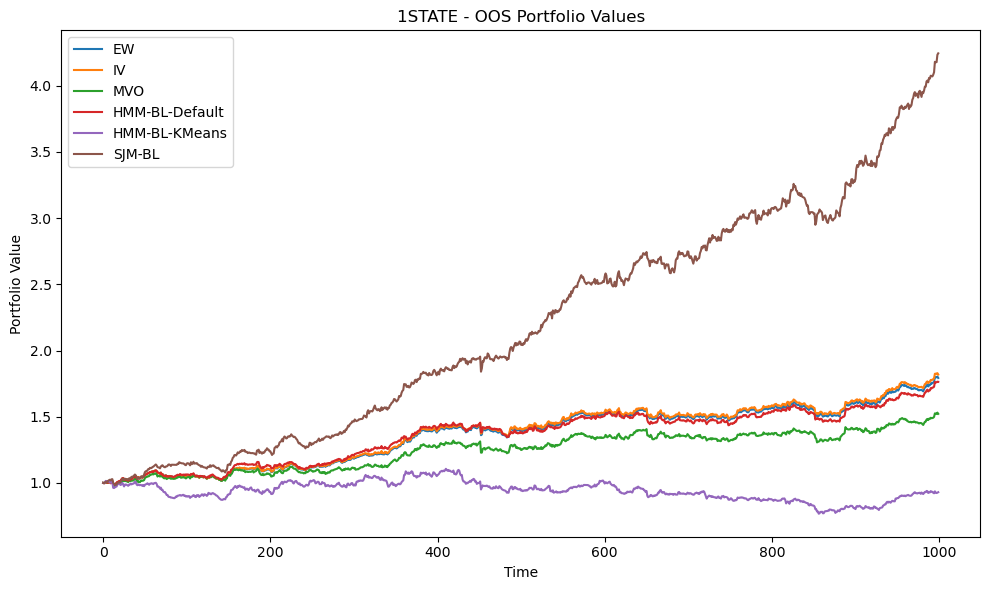

In [167]:
    # Example plot for the 1-state scenario
    scenario_key = "1state"
    pvs_1 = sim_results[scenario_key]["pvs"]
    plt.figure(figsize=(10, 6))
    for strat, vals in pvs_1.items():
        plt.plot(vals, label=strat)
    plt.title(f"{scenario_key.upper()} - OOS Portfolio Values")
    plt.xlabel("Time")
    plt.ylabel("Portfolio Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

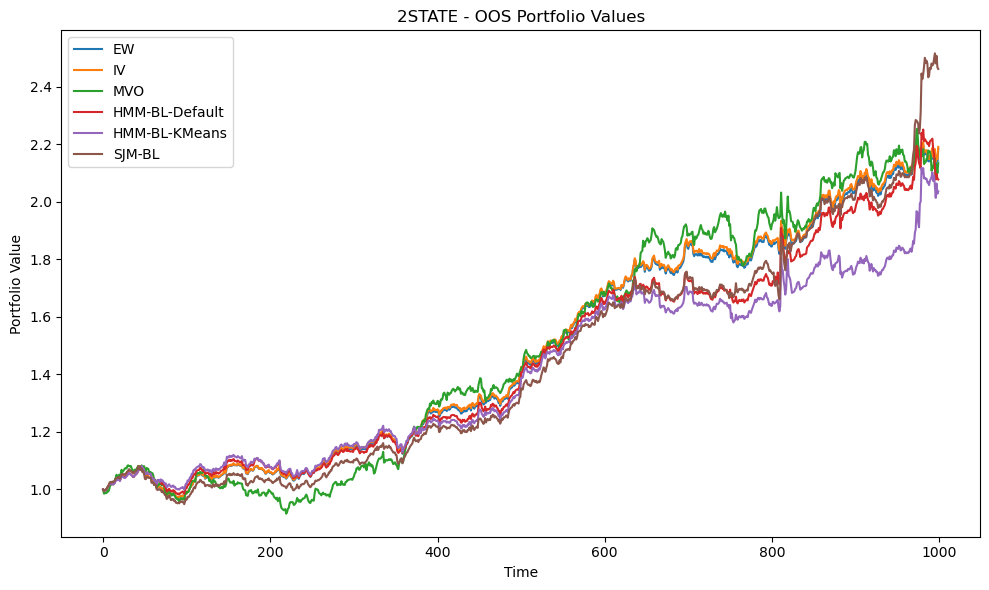

In [168]:
    # Example plot for the 2-state scenario
    scenario_key = "2state"
    pvs_1 = sim_results[scenario_key]["pvs"]
    plt.figure(figsize=(10, 6))
    for strat, vals in pvs_1.items():
        plt.plot(vals, label=strat)
    plt.title(f"{scenario_key.upper()} - OOS Portfolio Values")
    plt.xlabel("Time")
    plt.ylabel("Portfolio Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

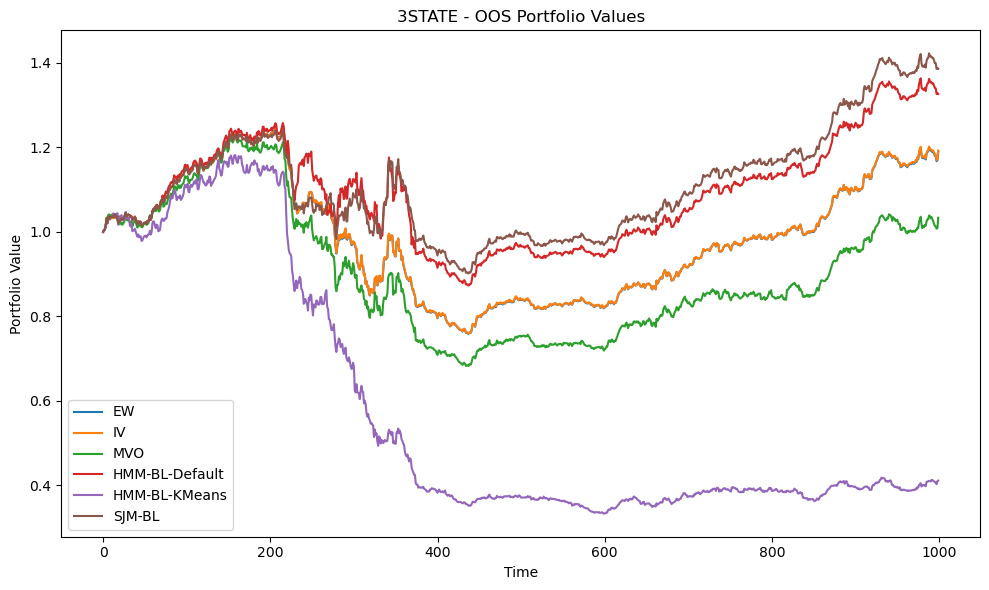

In [169]:
    # Example plot for the 3-state scenario
    scenario_key = "3state"
    pvs_1 = sim_results[scenario_key]["pvs"]
    plt.figure(figsize=(10, 6))
    for strat, vals in pvs_1.items():
        plt.plot(vals, label=strat)
    plt.title(f"{scenario_key.upper()} - OOS Portfolio Values")
    plt.xlabel("Time")
    plt.ylabel("Portfolio Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

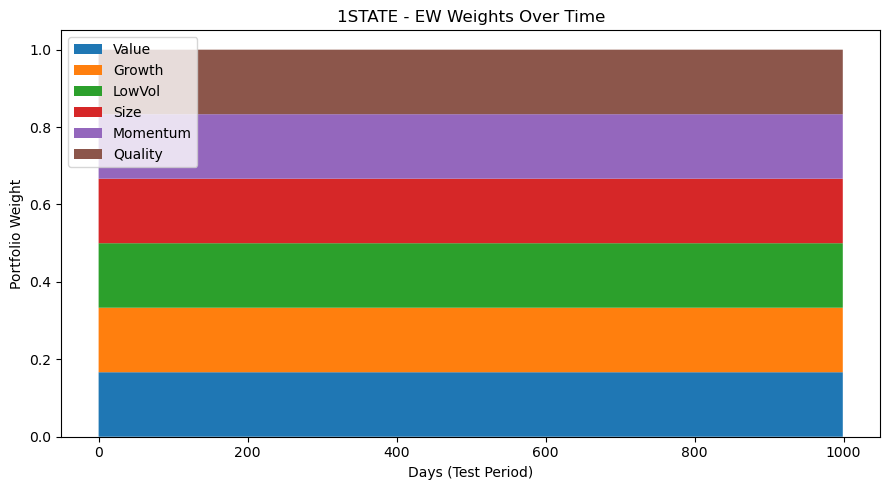

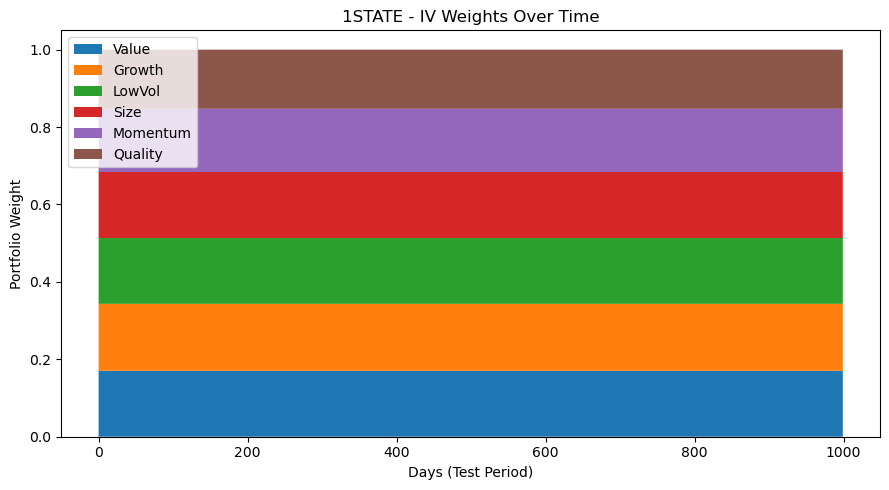

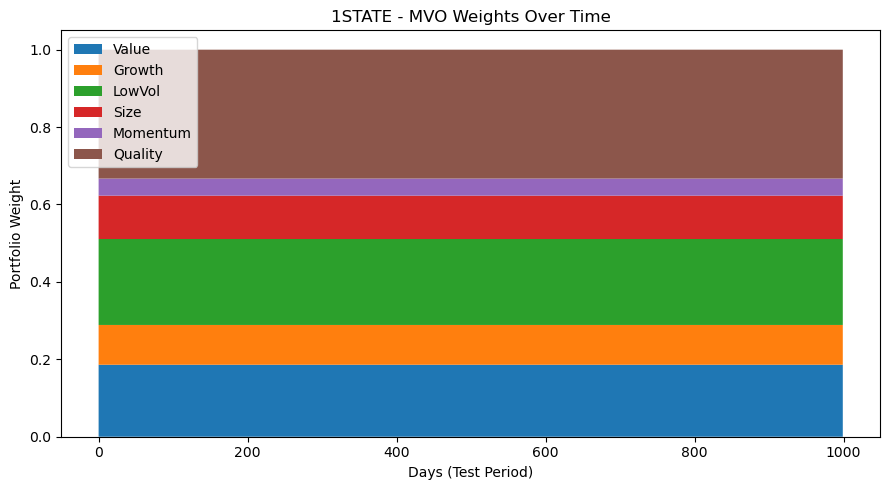

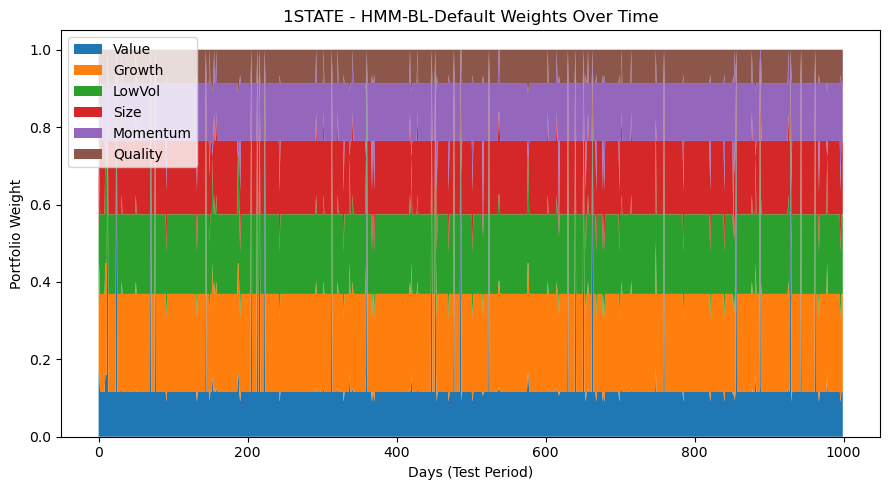

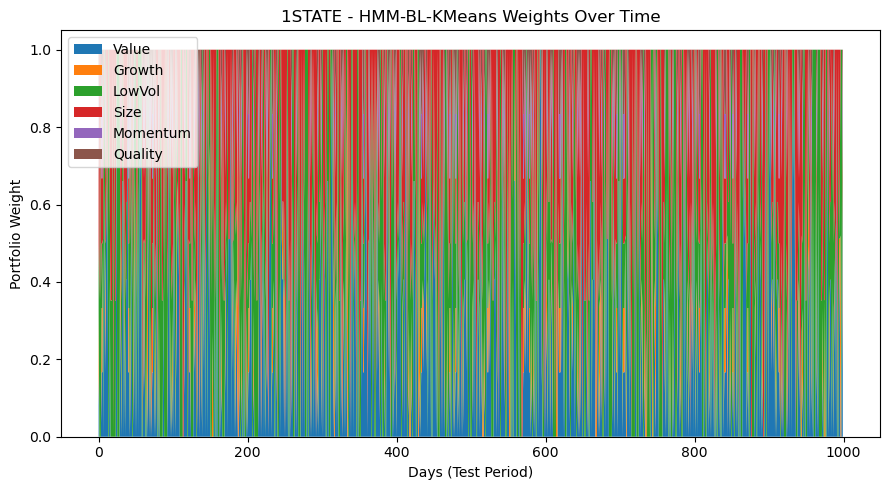

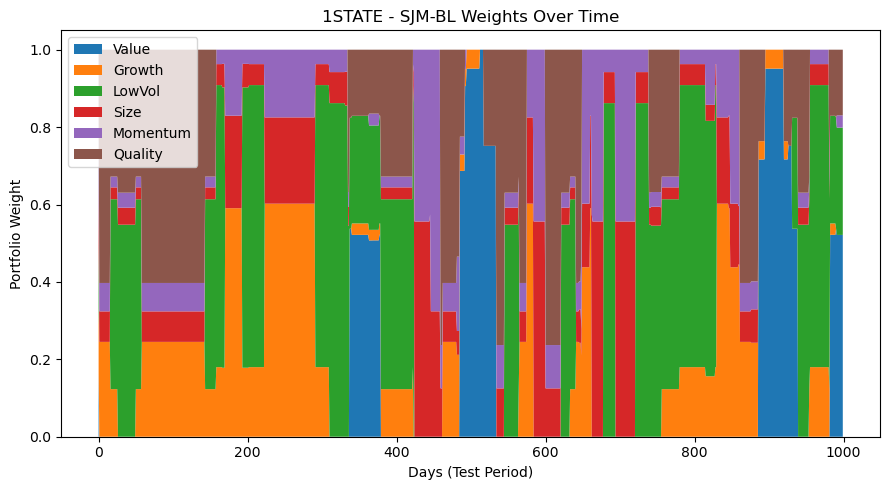

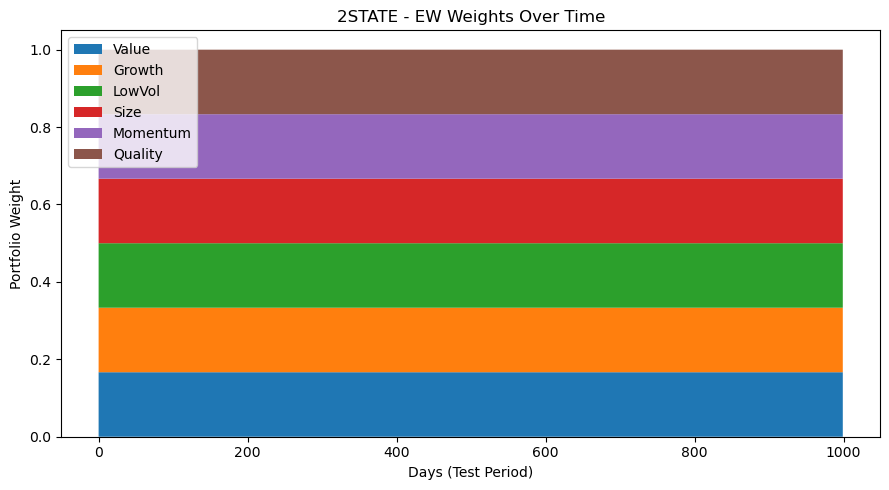

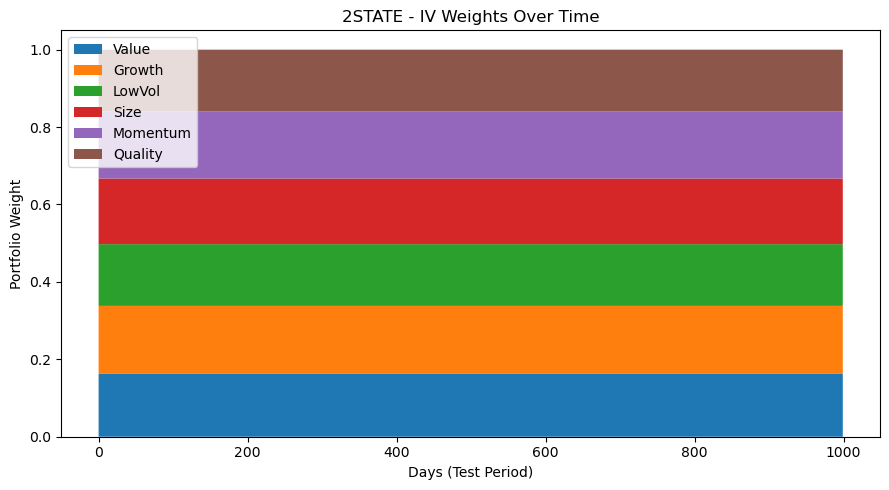

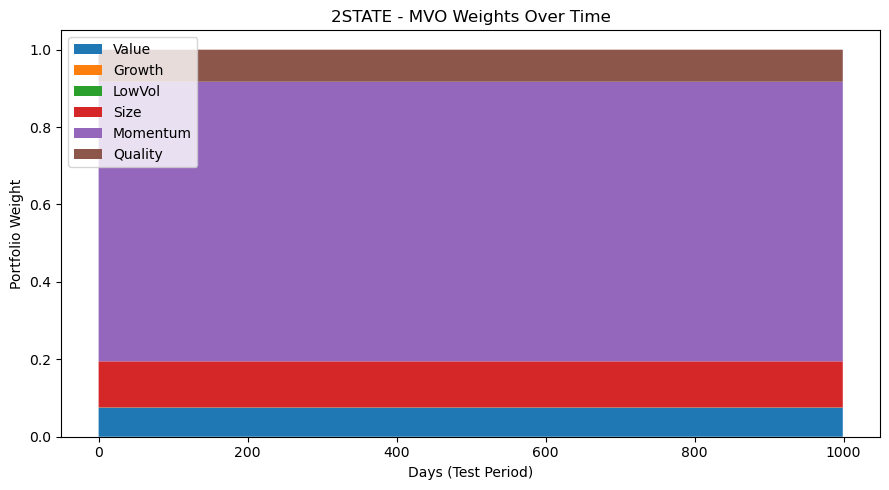

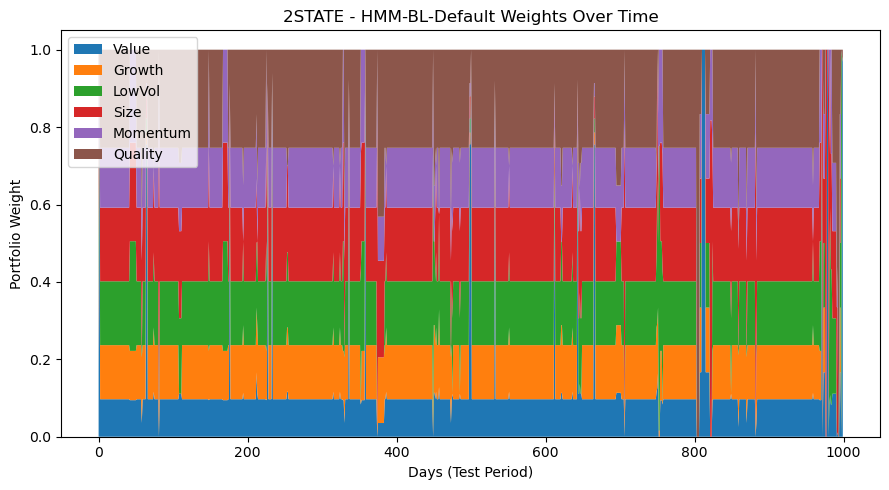

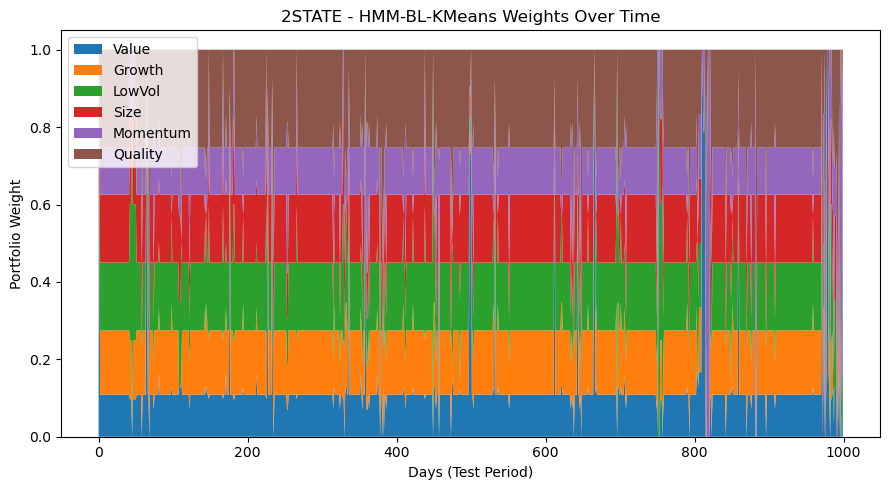

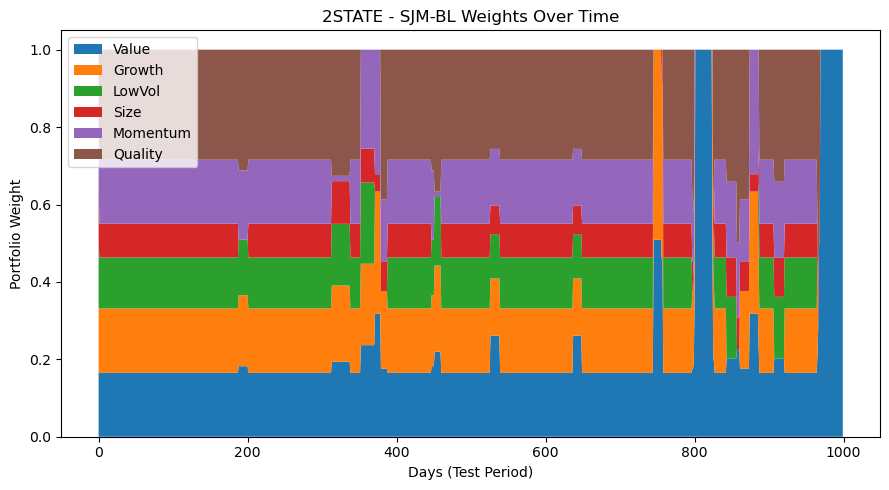

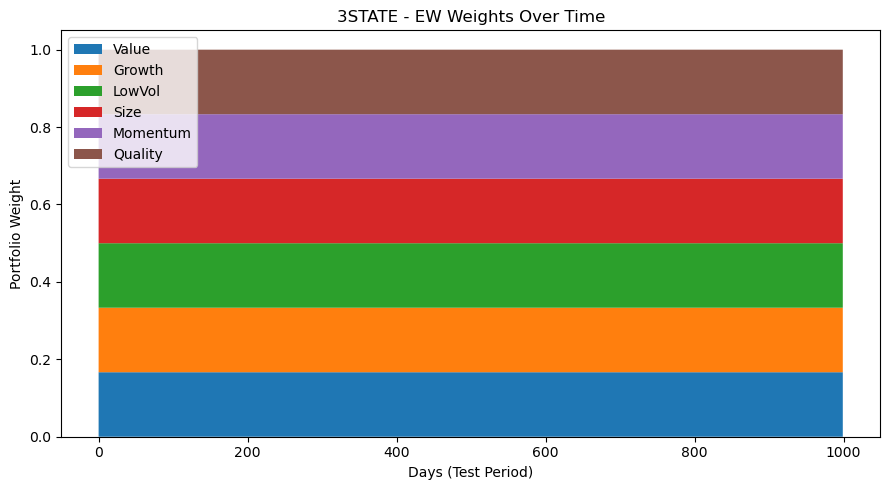

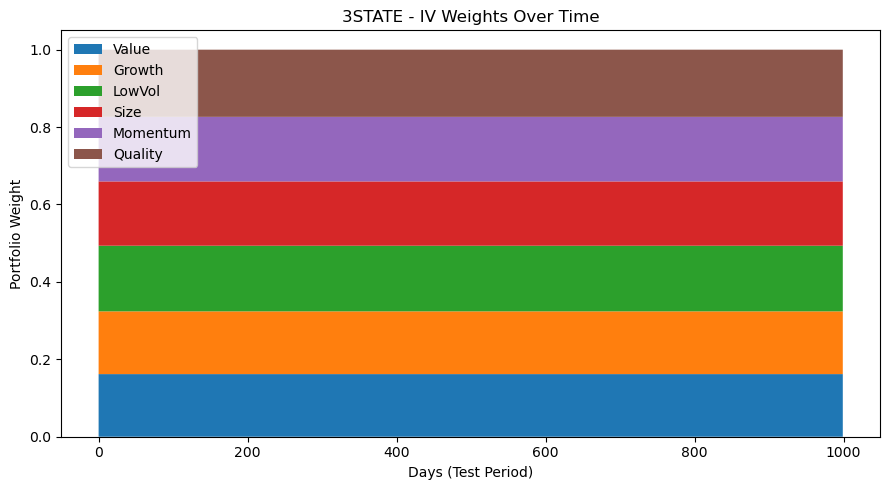

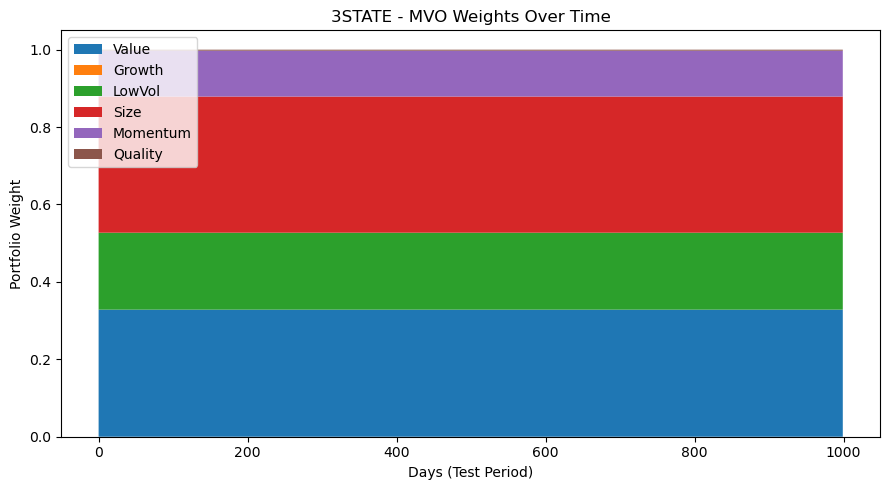

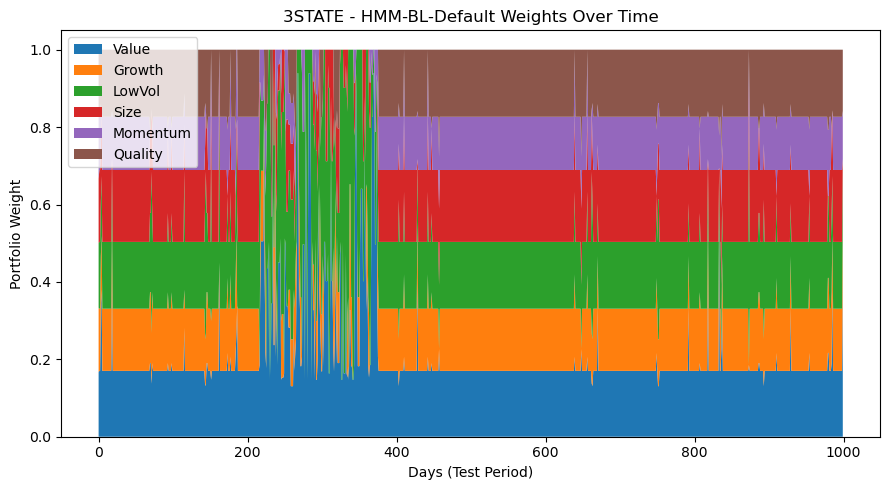

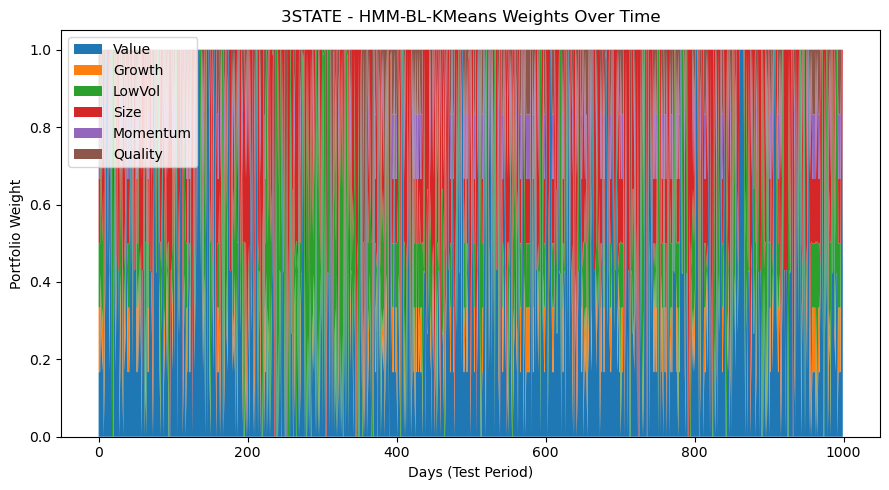

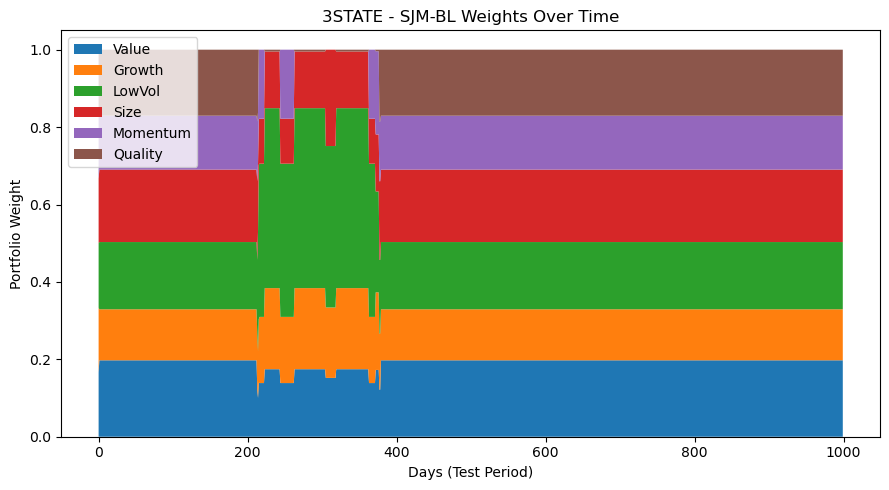

In [170]:
scenarios = ["1state", "2state", "3state"]
for scenario in scenarios:
    scenario_data = sim_results[scenario]["data"]
    weights_dict = scenario_data["weights"]    # dictionary of weight histories
    T_test = len(scenario_data["df_test"])
    
    for strategy, w_hist in weights_dict.items():
        plt.figure(figsize=(9, 5))
        
        # We assume w_hist is shape (T_test, N_ASSETS), 
        # so we do *w_hist.T to unpack each asset's time series for stackplot
        x_vals = np.arange(T_test)
        plt.stackplot(x_vals, *w_hist.T, labels=ASSETS)

        plt.title(f"{scenario.upper()} - {strategy} Weights Over Time")
        plt.xlabel("Days (Test Period)")
        plt.ylabel("Portfolio Weight")
        plt.legend(loc='upper left')
        plt.tight_layout()
        plt.show()

In [171]:
get_regime_means_single_asset(df_train["Value"], hmm_states_default_train[:, 0])

NameError: name 'df_train' is not defined

<function pypfopt.black_litterman.market_implied_risk_aversion(market_prices, frequency=252, risk_free_rate=0.0)>